In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

In [2]:
# constants
pi = np.pi
clight = 299792458
E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6


In [67]:
# input parameters
R_ring = 100e3/2/pi
GMTSQ = 90089.0664
Gamma = 89041.2788
Prad = 16.5e6
t_rad_long = 0.425
NperBunch = 7.077e10
N_bunch = 13551
h = 216816
QL = 4.7472e4
Vs = 35832080.5
Vq = 93359852.2
RoQ = 106.5*60
Qs = 0.028
sig_t = 8e-12

# calculate the derived parameters
beta = np.sqrt(1-1/Gamma**2)
v = clight*beta
f0 = v/(2*pi*R_ring)
T0 = 1/f0
frf = f0*h
wrf = 2*pi*frf
Trf = 1/frf
q_p_b = NperBunch*1.6e-19
I0 = q_p_b*N_bunch*f0


In [68]:
q_p_b

1.1323199999999999e-08

In [69]:
class Pattern:
    n_train = 1
    n_b_p_t = 1
    n_RF_btw_bunch = 1
    n_RF_p_gap = 0
    
    def __init__(self,a,b,c,d):
        self.n_train = a
        self.n_b_p_t = b
        self.n_RF_btw_bunch = c
        self.n_RF_p_gap = d

In [70]:
def Gaussian(data,A,x0,sigma):
    return A*np.exp(-(data-x0)**2/(2*sigma**2))

def Resonator(f,fr,R,Q):
    return R*f/(f+1j*Q*(fr-f**2/fr))

In [71]:
class Current:
    t = np.zeros(3)
    frq = np.zeros(3)
    I_t = np.zeros(3)
    I_f = np.zeros(3)
    def __init__(self,n_point,dt,pattern,I0,sig_t):
        self.t = np.array([(i+0.5)*dt for i in range(n_point)])
        self.I_t = np.zeros(n_point)
        self.I_f = np.zeros(n_point)
        self.frq = np.zeros(n_point)
        for train in range(pattern.n_train):
            for bunch in range(pattern.n_b_p_t):
                start_RF = (train*(pattern.n_b_p_t*pattern.n_RF_btw_bunch*train+pattern.n_RF_p_gap)+bunch*pattern.n_RF_btw_bunch)
                i_start = start_RF*n_slice_perRF
                i_end = (start_RF+1)*n_slice_perRF
                t0 = (start_RF+0.5)*Trf
                self.I_t[i_start:i_end] = Gaussian(self.t[i_start:i_end],I0,t0,sig_t)
    def fft(self,n_point,dt):
        
        self.I_f = np.fft.fft(self.I_t)/n_point
        #temp = cp.deepcopy(self.I_f[:int(n_point/2)])
        #self.I_f[:int(n_point/2)]=cp.deepcopy(self.I_f[int(n_point/2):])
        #self.I_f[int(n_point/2):] = cp.deepcopy(temp)
        
        self.frq = np.fft.fftfreq(n_point,dt)
        #self.frq = self.frq-self.frq[-1]
       

In [72]:
class Imp:
    frq = np.zeros(3)

In [73]:
# parameters for the grid
n_slice_perRF = 133 # need to be an odd number and the time coordinate each point represents is the time at the middle of the bin
dt = Trf/n_slice_perRF
n_point = h*n_slice_perRF

In [74]:
n_point

28836528

In [75]:
# generate time domain beam
pattern = Pattern(1,13551,16,0)
A_norm = q_p_b/(np.sqrt(2*pi)*sig_t)
I = Current(n_point,dt,pattern,A_norm,sig_t)
I.fft(n_point,dt)

In [76]:
# generate the frq domain impedance
fr = f0*h
Q = 4.7e4
R = RoQ*Q
Z = Resonator(I.frq,fr,R,Q)

In [77]:
# calculate the V
Vg_t = -Vs*np.cos(wrf*I.t)+Vq*np.sin(wrf*I.t)
V_f = -I.I_f*Z
V_t = np.fft.ifft(V_f)

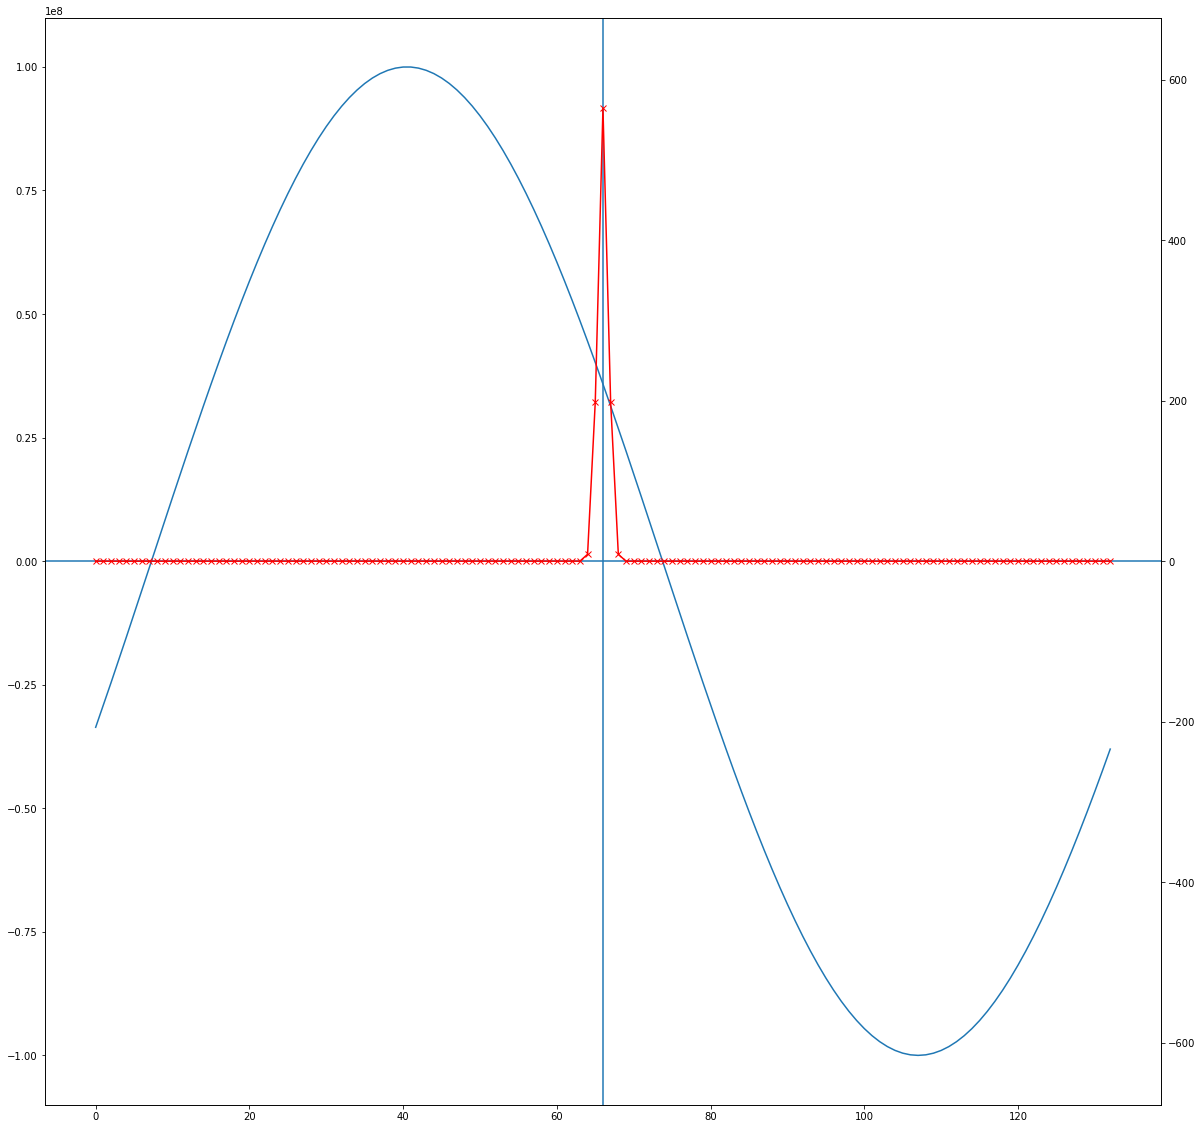

In [78]:
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(20)
fig1.set_figwidth(20)
i_bunch = 0
n_RF_to_see = 1
rng1 = n_slice_perRF*i_bunch*pattern.n_RF_p_gap
rng2 = rng1+n_slice_perRF*n_RF_to_see
axes1.plot(np.real(Vg_t[rng1:rng2]))
axes1.axhline(y=0)
axes1.axvline(x=int((rng2-rng1)/2))

ax2 = axes1.twinx()
ax2.plot(np.real(I.I_t[rng1:rng2]),'rx-')
ax2.set_ylim([-np.max(np.real(I.I_t[rng1:rng2]))*1.2,np.max(np.real(I.I_t[rng1:rng2]))*1.2])
plt.show()

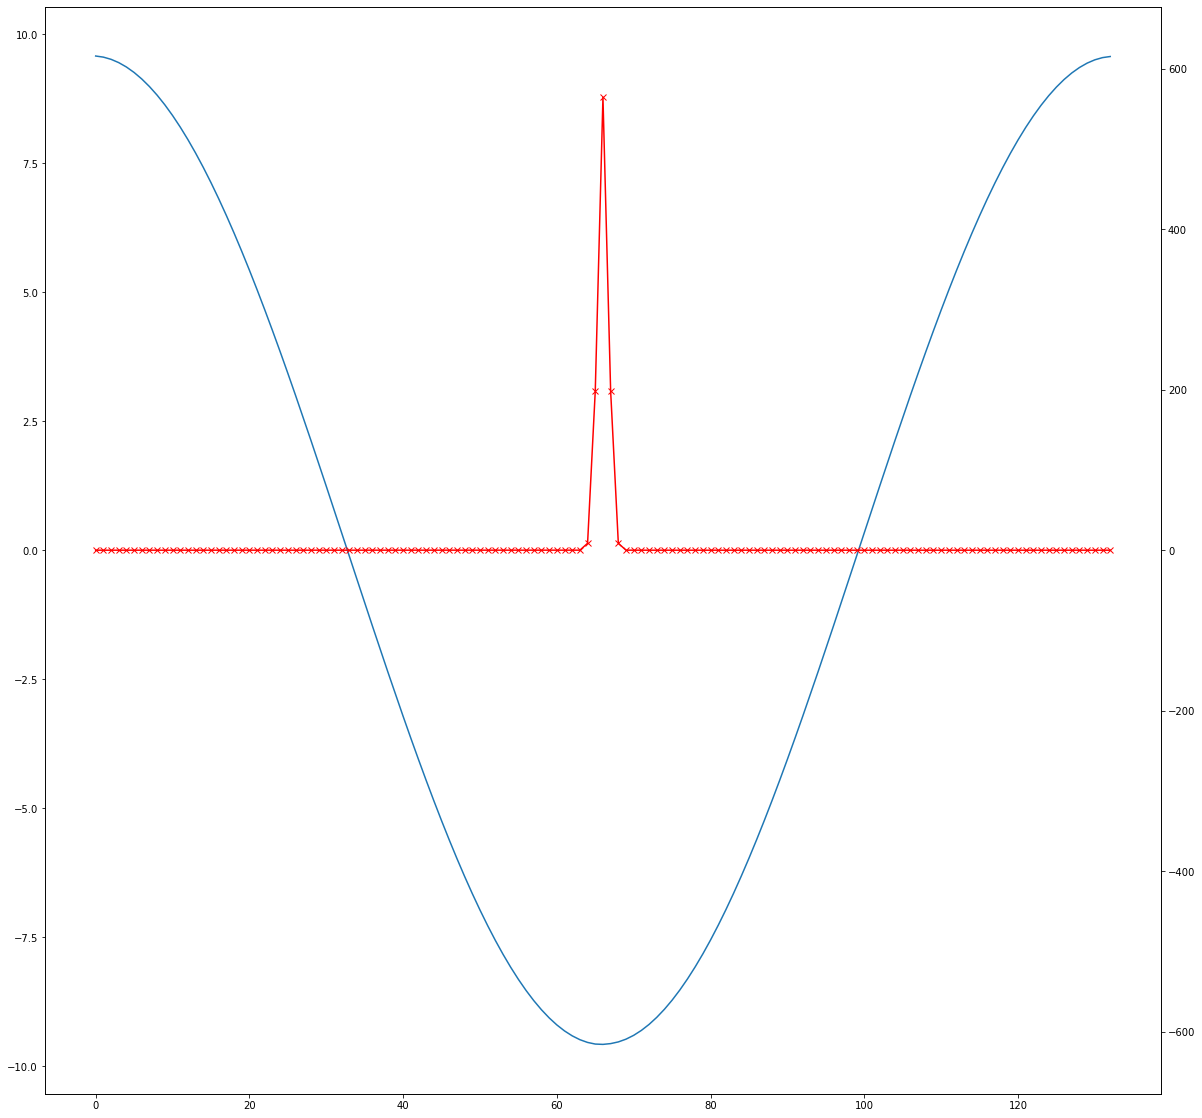

In [79]:
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(20)
fig1.set_figwidth(20)
i_bunch = 0
n_RF_to_see = 1
rng1 = n_slice_perRF*i_bunch*pattern.n_RF_p_gap
rng2 = rng1+n_slice_perRF*n_RF_to_see
axes1.plot(np.real(V_t[rng1:rng2]))

ax2 = axes1.twinx()
ax2.plot(np.real(I.I_t[rng1:rng2]),'rx-')
ax2.set_ylim([-np.max(np.real(I.I_t[rng1:rng2]))*1.2,np.max(np.real(I.I_t[rng1:rng2]))*1.2])
plt.show()

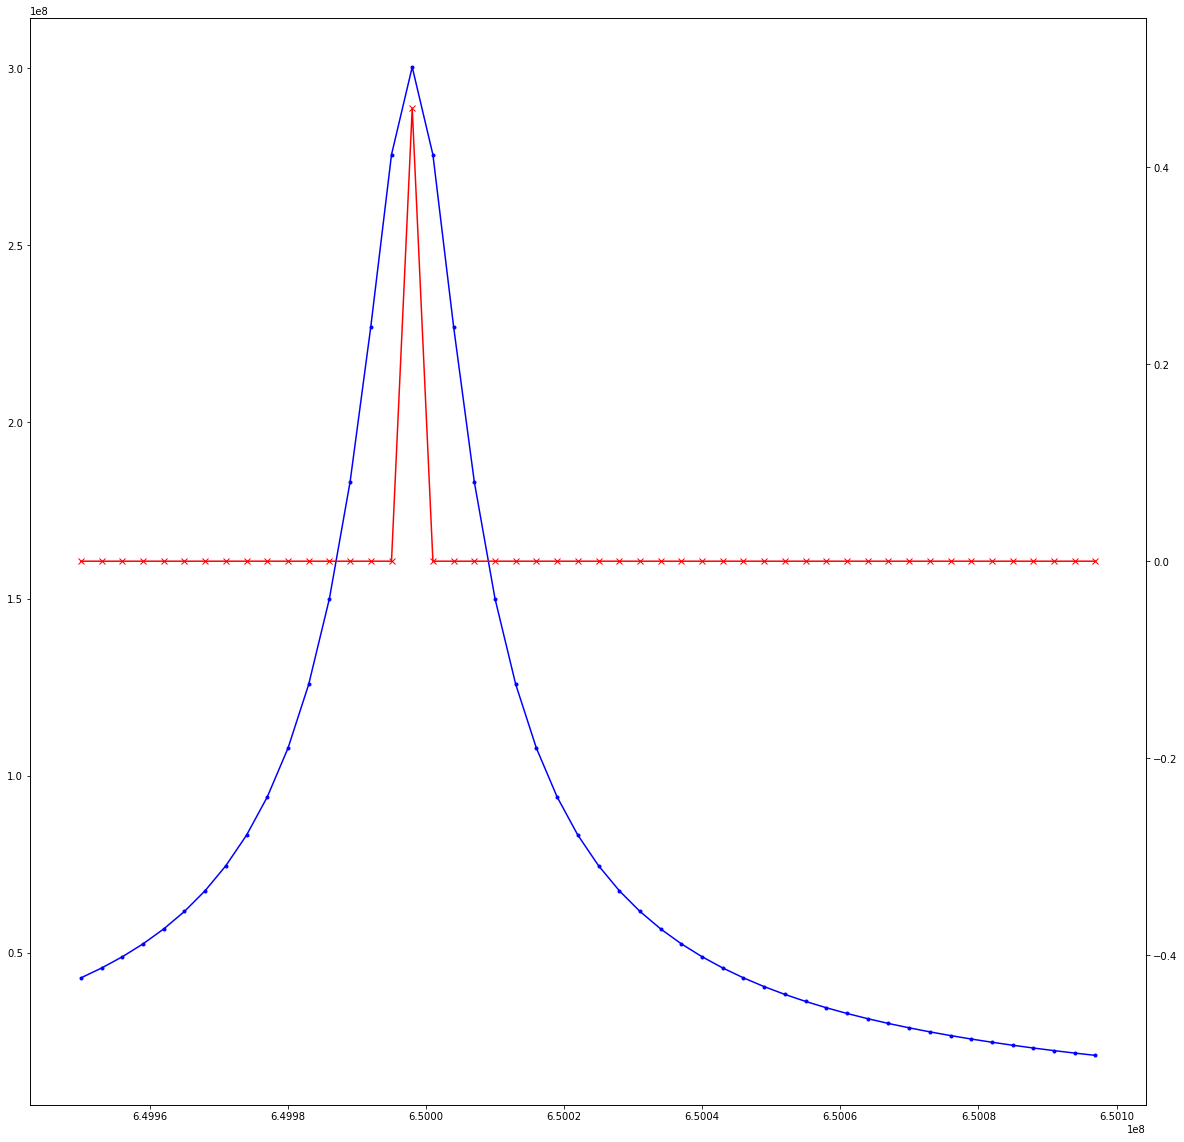

In [104]:
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(20)
fig1.set_figwidth(20)
i_bunch = 0
n_RF_to_see = 1
rng1 = 216800
rng2 = 216850
axes1.plot(I.frq[rng1:rng2],np.abs(Z[rng1:rng2]),'b.-')

ax2 = axes1.twinx()
ax2.plot(I.frq[rng1:rng2],np.abs(I.I_f[rng1:rng2]),'rx-')
ax2.set_ylim([-np.max(np.real(np.abs(I.I_f[rng1:rng2])))*1.2,np.max(np.real(np.abs(I.I_f[rng1:rng2])))*1.2])
plt.show()

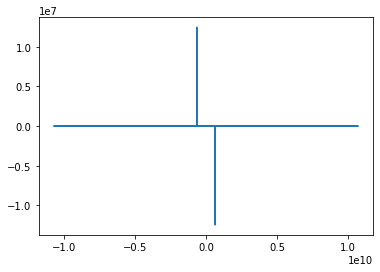

In [26]:
plt.plot(I.frq,np.imag(V_f))

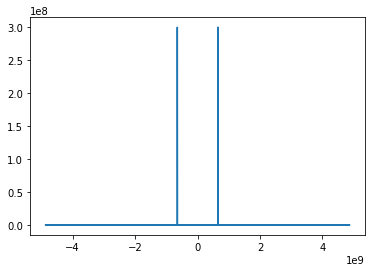

In [16]:
plt.plot(I.frq,np.abs(Z))

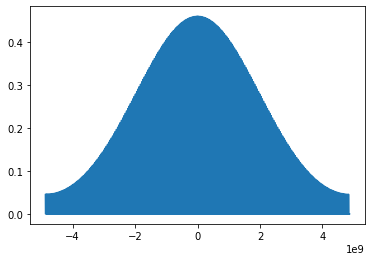

In [17]:
plt.plot(I.frq,np.abs(I.I_f))

In [18]:
n_slice_perRF

15

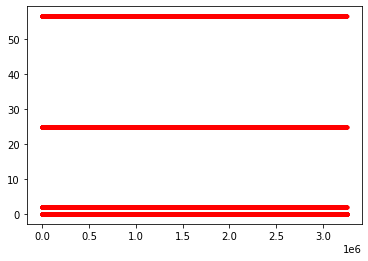

In [19]:
plt.plot(np.abs(I.I_t[:]+1e-20),'r.')